In [3]:
# --- Ottimizzazione ---
# La libreria fondamentale per interagire con il solutore Gurobi
import gurobipy as gp
from gurobipy import GRB

# --- Gestione Dati e Calcolo Numerico ---
# Per leggere e manipolare dati in tabelle (DataFrame)
import pandas as pd
# Per calcoli numerici efficienti, specialmente con array
import numpy as np

# --- Visualizzazione dei Risultati ---
# La libreria base per creare grafici e plot
import matplotlib.pyplot as plt
# Un'estensione di matplotlib per grafici statistici più belli
import seaborn as sns

# --- Utilità per Grafi e Barre di Avanzamento ---
# Per creare e manipolare la rete di aeroporti
import networkx as nx
# Per mostrare barre di avanzamento durante i calcoli lunghi (molto comodo!)
from tqdm.notebook import tqdm

# --- Impostazioni Aggiuntive (Opzionale) ---
# Per rendere i grafici di seaborn più belli
sns.set_theme(style="whitegrid")
# Per evitare che pandas mostri i numeri in notazione scientifica
pd.set_option('display.float_format', lambda x: '%.5f' % x)

print("Librerie importate con successo!")

Librerie importate con successo!


In [10]:
# Numero di aeroporti da generare per il nostro test
numero_aeroporti = 5

# Creiamo coordinate casuali in un'area di 1000x1000 km per avere delle distanze
# Usiamo un "seed" per assicurarci che i numeri casuali siano sempre gli stessi
# ogni volta che esegui il codice, così i risultati saranno riproducibili.
np.random.seed(42) 
coords_x = np.random.randint(0, 1000, size=numero_aeroporti)
coords_y = np.random.randint(0, 1000, size=numero_aeroporti)

# Creiamo la tabella (DataFrame) con i nostri dati
airports_df = pd.DataFrame({
    'airport_id': range(numero_aeroporti),
    'x': coords_x,
    'y': coords_y
})

# Salviamo la tabella in un file CSV che il nostro programma potrà leggere
file_name = 'airports.csv'
airports_df.to_csv(file_name, index=False)

print(f"File '{file_name}' creato con successo con {numero_aeroporti} aeroporti.")
print("Ora puoi eseguire la cella successiva con il modello Gurobi.")

# Mostriamo un'anteprima dei dati generati
print("\nEcco un'anteprima dei dati:")
print(airports_df.head())

File 'airports.csv' creato con successo con 5 aeroporti.
Ora puoi eseguire la cella successiva con il modello Gurobi.

Ecco un'anteprima dei dati:
   airport_id    x    y
0           0  102   71
1           1  435  700
2           2  860   20
3           3  270  614
4           4  106  121


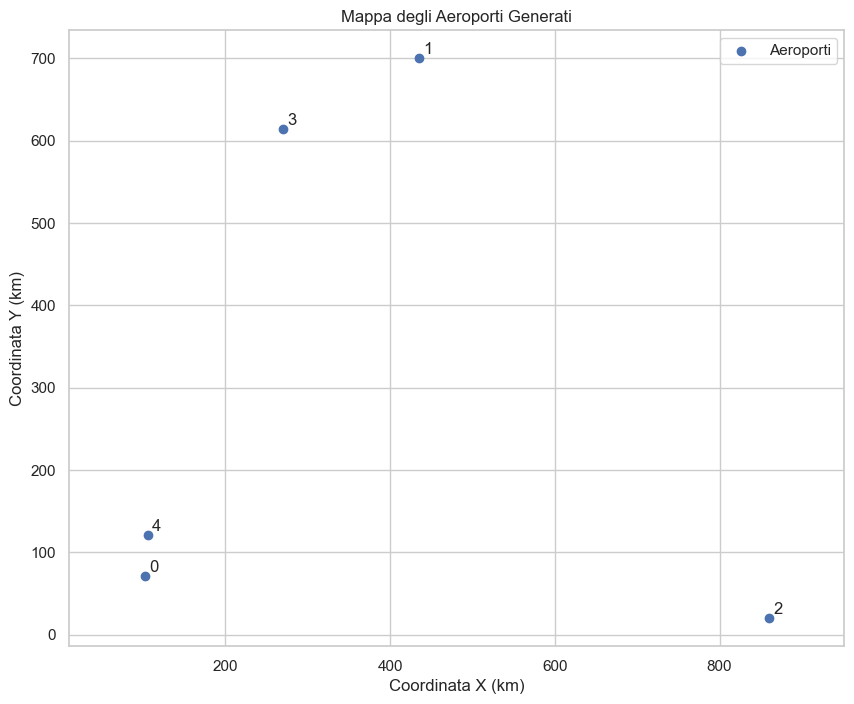

In [11]:
try:
    # --- Creazione del Grafico ---
    # Imposta le dimensioni della figura per renderla più leggibile
    plt.figure(figsize=(10, 8))
    
    # Crea un grafico a dispersione con le coordinate x e y degli aeroporti
    plt.scatter(airports_df['x'], airports_df['y'], label='Aeroporti')
    
    # --- Aggiunta delle Etichette per ogni Aeroporto ---
    # Aggiunge un'etichetta con l'ID accanto a ogni punto per identificarlo
    for i, row in airports_df.iterrows():
        plt.text(row['x'] + 5, row['y'] + 5, str(row['airport_id']))
        
    # --- Abbellimento del Grafico ---
    plt.title('Mappa degli Aeroporti Generati')
    plt.xlabel('Coordinata X (km)')
    plt.ylabel('Coordinata Y (km)')
    plt.grid(True)
    plt.legend()
    plt.axis('equal') # Mantiene le proporzioni corrette tra x e y
    
    # Mostra il grafico
    plt.show()

except NameError:
    print("Errore: la variabile 'airports_df' non è definita.")
    print("Assicurati di eseguire prima la cella che crea o carica i dati.")
except Exception as e:
    print(f"Si è verificato un errore durante la creazione del grafico: {e}")

In [12]:
# Esempio di codice per calcolare rho_i
try:
    # Numero di basi di ricarica da installare (puoi cambiarlo)
    p = 5 
    
    # Dati caricati dalla cella precedente
    airports = airports_df.index.tolist()
    coords = airports_df[['x', 'y']].to_numpy()
    dist = np.linalg.norm(coords[:, np.newaxis, :] - coords[np.newaxis, :, :], axis=2)

    # --- Creazione del Modello Gurobi ---
    m = gp.Model("shortest_path_model")

    # --- Variabili di Decisione ---
    # y[j] = 1 se l'aeroporto j è una base di ricarica
    y = m.addVars(airports, vtype=GRB.BINARY, name="y")
    
    # rho[i] = distanza minima da i alla base più vicina
    rho = m.addVars(airports, vtype=GRB.CONTINUOUS, name="rho")
    
    # w[i,j] = 1 se il percorso minimo da i passa per il vicino j
    # Creiamo le variabili solo per le coppie di aeroporti esistenti
    w = m.addVars(airports, airports, vtype=GRB.BINARY, name="w")
    
    # chi[i] = 1 se l'aeroporto i è isolato (non implementato in questo esempio base)
    
    # Funzione Obiettivo: per ora, minimizziamo la somma delle distanze
    m.setObjective(gp.quicksum(rho[i] for i in airports), GRB.MINIMIZE)

    # --- Vincoli ---
    # 1. Installa esattamente p basi di ricarica
    m.addConstr(gp.quicksum(y[j] for j in airports) == p, name="num_facilities")

    # Vincoli (12)-(16) per il calcolo di rho_i
    # Per semplicità, qui M1 e M2 sono valori grandi, ma dovrai calcolarli
    # come descritto nel paper per il progetto finale.
    M1 = 10000 
    M2 = 10000
    
    for i in airports:
        # Vincolo (12): se i è una base, la sua distanza è 0
        m.addConstr(rho[i] <= M1 * (1 - y[i]), name=f"rho_is_base_{i}")
        
        # Vincolo (16) semplificato: o i è una base, o si collega a un vicino
        m.addConstr(y[i] + gp.quicksum(w[i,j] for j in airports if i != j) == 1, name=f"switch_{i}")
        
        for j in airports:
            if i == j: continue
            
            # Vincolo (13): limite superiore su rho_i
            m.addConstr(rho[i] <= dist[i,j] + rho[j], name=f"rho_upper_{i}_{j}")
            
            # Vincolo (14): limite inferiore su rho_i
            m.addConstr(rho[i] >= dist[i,j] + rho[j] - M2 * (1 - w[i,j]), name=f"rho_lower_{i}_{j}")


    # Risolvi il modello
    m.optimize()

    # Stampa i risultati
    if m.Status == GRB.OPTIMAL:
        print("\nSoluzione trovata!")
        active_bases = [j for j in airports if y[j].X > 0.5]
        print(f"Basi di ricarica installate in: {active_bases}")
        
        for i in airports:
            if i in active_bases:
                print(f"Aeroporto {i} (BASE): distanza rho = {rho[i].X:.2f}")
            else:
                # Trova per quale vicino j w[i,j] è 1
                next_hop = [j for j in airports if i != j and w[i,j].X > 0.5][0]
                print(f"Aeroporto {i}: distanza rho = {rho[i].X:.2f} (via aeroporto {next_hop})")

except NameError:
    print("Assicurati di aver prima caricato i dati nella variabile 'airports_df'.")
except Exception as e:
    print(f"Si è verificato un errore: {e}")

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 PRO 5650U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 51 rows, 35 columns and 140 nonzeros
Model fingerprint: 0x6bc6c4bd
Variable types: 5 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%

Soluzione trovata!
Basi di ricarica installate in: [0, 1, 2, 3, 4]
Aeroporto 0 (BASE): distanza rho = 0.00
Aeroporto 1 (BASE): distanz